In [89]:
! git clone https://github.com/LorMolf/WeWereOnABreak.git

In [ ]:
!pip install pgmpy
!pip install texttable

In [ ]:
% cd WeWereOnABreak/src

# We Were On A Break - DEMO

This is an example of usage of the *WeWereOnABreak* framework, an immplementation of the *Chinese wispers* game (a.k.a. Telephone game) with the following rules. 

Each player:
 1. takes the input sentence
 2. translates it into Italian
 3. translates it back to English
 4. passes the message to the next player without the others hearing it

Communications between each pair of players are affected by noise, whose value ranges in the *Bit Error Rate* scale, being $BER_1$ and $BER_5$ the best and worst case scanario, respectively.

The user can define the structure of the Bayesian Network by tweaking the `num_players` and `modality` parameters, each of which implements different types of structures. 

`TheQueryMen` is a wrapper class for the creation and a user-friendly usage of the Bayesian Network model provided by the `pgmpy` library. You can select one of the available modality:
- **flat** mode: test the survivability of the original message 
- **survivability** mode: as for *flat mode* but with a different network architecture
- **hardcore** mode: make it possible to retrieve information about the most probable output of the network given the chosen input sentence


The possible message the user can input to the Network are all taken from the subtitles  of the whole first season of `Friends`. For each available line in the dataset, the score is computed according to the words they share and to the number and type of synonyms and misspellings. 

In [ ]:
from theQuarryMen import TheQueryMen
import matplotlib.pyplot as plt
import numpy as np
import time

Let us select a specific message so as to compare the probability of success of a random sentence with the same `switching_score` as the Bayesian Network's structure changes along with the game modality.

In [ ]:
dummy_model = TheQueryMen(numOfPlayers=3,modality='hardcore')

STATISTICS LOADED !
Building the Bayesian Network...
The BN is ready to be queried !


In [ ]:
id_source_line, source_line = dummy_model.generateSource()


SOURCE MESSAGE: there's nothing to tell. it's just some guy i work with.  



Note that, to avoid a cyclic architecture, the player starting the chain of word-of-mouth is represented twice, at the beginning and the end of the Network, respectively as the $SOURCE$ and ${DECODER}_n$ node, being $n$ the number of players.

Querying whether the source line comes back untouched at the starting point is here translated into asking whether ${DECODER}_n$ is equal to $SOURCE$.

## Flat mode

At first, let's implement the simplest available BN structure and query the probability of a line to return back to the initial player withouth any modification.




In [ ]:
flat_model = TheQueryMen(numOfPlayers=3,modality='flat',noiseParamsDistr=[0.1,0.1,0.1])
id_line, str_line = flat_model.generateSource(source_line)

STATISTICS LOADED !
Building the Bayesian Network...
The BN is ready to be queried !


In [ ]:
query = ['DECODER_3']
prop_success = flat_model.makeExactQuery(variables=query,printCPD=True)

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

+--------------+------------------+
| DECODER_3    |   phi(DECODER_3) |
+==============+==================+
| DECODER_3(0) |           0.6779 |
+--------------+------------------+
| DECODER_3(1) |           0.3221 |
+--------------+------------------+


where the Variable Elimination Algorithm is here used.

For the given number of players, the BN's structure is the following.

In [ ]:
nodes=flat_model.BN.edges
for node in nodes:
  print(node)

('EbNO', 'BER_0')
('BER_0', 'DECODER_0')
('BER_0', 'BER_1')
('C/I', 'BER_0')
('Phi', 'BER_0')
('SOURCE', 'DECODER_0')
('DECODER_0', 'DECODER_1')
('DECODER_1', 'DECODER_2')
('BER_1', 'DECODER_1')
('BER_1', 'BER_2')
('DECODER_2', 'DECODER_3')
('BER_2', 'DECODER_2')
('BER_2', 'BER_3')
('BER_3', 'DECODER_3')


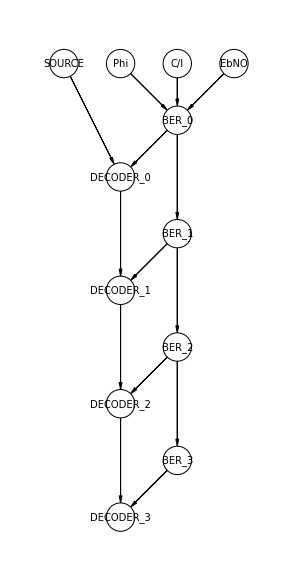

In [ ]:
import daft
from daft import PGM

pgm = PGM(shape=[5, 10])

#node_names=list(np.unique([endPoint for node in nodes for endPoint in node]))
pgm.add_node(daft.Node('SOURCE', r"SOURCE", 1, 9))

pgm.add_node(daft.Node('Phi', r"Phi", 2, 9))
pgm.add_node(daft.Node('C/I', r"C/I", 3, 9))
pgm.add_node(daft.Node('EbNO', r"EbNO", 4, 9))

pgm.add_node(daft.Node('BER_0', r"BER_0", 3, 8))
pgm.add_node(daft.Node('DECODER_0',r'DECODER_0',2,7))

pgm.add_node(daft.Node('BER_1', r"BER_1", 3, 6))
pgm.add_node(daft.Node('DECODER_1',r'DECODER_1',2,5))

pgm.add_node(daft.Node('BER_2', r"BER_2", 3, 4))
pgm.add_node(daft.Node('DECODER_2',r'DECODER_2',2,3))

pgm.add_node(daft.Node('BER_3', r"BER_3", 3, 2))
pgm.add_node(daft.Node('DECODER_3',r'DECODER_3',2,1))

for edge in nodes:
  pgm.add_edge(edge[0],edge[1])

pgm.render()
plt.show()

Let's now compare the results as the number of players grows. For this purpose, the method `TheQueryMen.alwaysUnchanged` is implemented to query the model the probability that the transmission of the message is correct for each node in the network.

In [ ]:
num_players=[2,4,5,6,8,9]
prob_of_success=[]

In [ ]:
for num_pl  in num_players:
    flat_bn = TheQueryMen(num_pl,modality='flat')
    flat_bn.generateSource(source_line)

    res=flat_bn.alwaysUnchanged()

    prob_of_success.append(res)

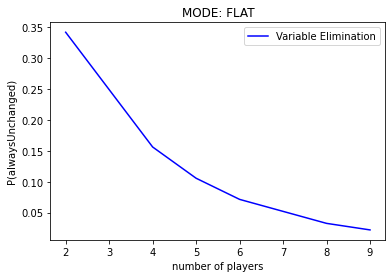

In [ ]:
fig, ax = plt.subplots()
plt.title("MODE: FLAT")

ax.plot(num_players,prob_of_success,'b',label='Variable Elimination')

ax.set_xlabel('number of players')
ax.set_ylabel('P(alwaysUnchanged)')

plt.legend()
plt.show()

### Approximate queries - Sampling strategies

Since the spatial needs of the Network grow linearly with the cardinality of our dataset of possible sentences, a computationally cheap method for querying is required. In this regard, some approximate approaches have been implemented.

In particular, it is possible to ask the model to sample from data with different strategies. *Rejection, likely-weighted* and *Gibbs* sampling are employable by way of the method `TheQueryMen.makeApproximateQuery`.

Let us then compare performances between the exact method and the approximate ones. We shall consider the rejection and likely-weighted sampling strategies.

In [ ]:
num_players = [5,7,9,12,15,18,20]
exact_times, rej_times, lw_times = [], [], []

delta_prediction = []

In [ ]:
for num_pl in num_players:
  surv_model = TheQueryMen(num_pl,modality='flat')
  surv_model.generateSource(source_line)

  query=[f'DECODER_{num_pl}']  

  start=time.time()
  exact=surv_model.makeExactQuery(query)[0]
  exact_times.append(time.time()-start)

  start=time.time()
  rej=surv_model.makeApproximateQuery(variables=query,sampling_type='rej')[0]
  rej_times.append(time.time()-start)

  start=time.time()
  lw=surv_model.makeApproximateQuery(query,sampling_type='lw')[0]
  lw_times.append(time.time()-start)

  delta_prediction.append(min(exact-rej,exact-lw))

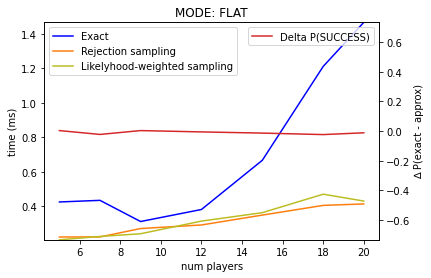

In [ ]:
fig, ax1 = plt.subplots()
plt.title("MODE: FLAT")

ax2 = ax1.twinx()
ax1.plot(num_players,exact_times,'b',label='Exact')
ax1.plot(num_players,rej_times,'tab:orange',label='Rejection sampling')
ax1.plot(num_players,lw_times,'tab:olive',label='Likelyhood-weighted sampling')

ax2.plot(num_players,delta_prediction,'tab:red',label="Delta P(SUCCESS)")

ax1.set_xlabel('num players')
ax1.set_ylabel('time (ms)')
ax2.set_ylabel("∆ P(exact - approx)")

min_y=min(exact_times+rej_times+lw_times)
max_y=max(exact_times+rej_times+lw_times)
ax1.set_ylim(min_y,max_y)
ax2.set_ylim(-max_y/2,max_y/2)

ax1.legend()
ax2.legend()
plt.show()

## Survivability mode

This modality is quite similar to the previous one, with the only difference in how the $SOURCE$ node's CPD Table is composed.

At first, we compute the probability of success of the line picked before to make some comparison with the *flat* mode.


In [ ]:
print(f"ORIGINAL MESSAGE: {source_line}")

surv_model = TheQueryMen(3,modality='survivability')
id_line, str_line = surv_model.generateSource(source_line)

query = ['DECODER_3']
prop_success = surv_model.makeExactQuery(variables=query,evidence={'SOURCE':id_source_line},printCPD=True)

ORIGINAL MESSAGE: there's nothing to tell. it's just some guy i work with.  
STATISTICS LOADED !
Building the Bayesian Network...
The BN is ready to be queried !


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

+--------------+------------------+
| DECODER_3    |   phi(DECODER_3) |
+==============+==================+
| DECODER_3(0) |           0.6783 |
+--------------+------------------+
| DECODER_3(1) |           0.3217 |
+--------------+------------------+


where we witness a substantial equality with the *flat* modality in terms of result. On the other hand, we may be interested in pointing out how the Variable Elimination algorithm - used in the "exact" queries perfomed so far - is affected by the higher cardinality of the $SOURCE$ node for the *survivability* modality in terms of time performances. 

In [ ]:
num_players = [2,5,7,9,12]
flat_times, surv_times = [], []

In [ ]:
for num_pl in num_players:
  flat_model = TheQueryMen(num_pl,modality='flat')
  flat_model.generateSource(source_line)

  query = [f'DECODER_{num_pl}'] # assess success of the last communication path

  surv_model = TheQueryMen(num_pl,modality='survivability')
  surv_model.generateSource(source_line)

  start=time.time()
  flat_model.makeExactQuery(query,evidence={},printCPD=False)
  flat_times.append(time.time()-start)

  start=time.time()
  surv_model.makeExactQuery(query,evidence={},printCPD=False)
  surv_times.append(time.time()-start)

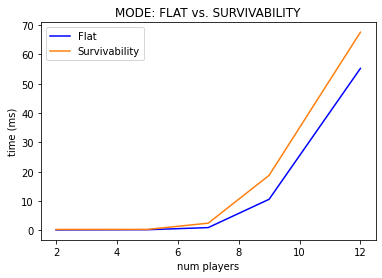

In [ ]:
def plot_times_Flat_vs_Surv(num_players,flat_times,surv_times):
  fig, ax = plt.subplots()
  plt.title("MODE: FLAT vs. SURVIVABILITY")

  ax.plot(num_players,flat_times,'b',label='Flat')
  ax.plot(num_players,surv_times,'tab:orange',label='Survivability')

  ax.set_xlabel('num players')
  ax.set_ylabel('time (ms)')

  plt.legend()
  plt.show()

plot_times_Flat_vs_Surv(num_players,flat_times,surv_times)

The latter experiment showed how the cardinality of the CPDs effectively affects the Variable Elimination algorithm's performances if no custom sort of variables is specified.

Since the two modalities share all the CPDs but the SOURCE one, one could try giving an order that consider the latter as soon as the algorithm starts.

In [ ]:
flat_times, surv_times = [], []

for num_pl in num_players:
  flat_model = TheQueryMen(num_pl,modality='flat')
  flat_model.generateSource(source_line)

  query = [f'DECODER_{num_pl}'] # assess the success of the last communication path

  surv_model = TheQueryMen(num_pl,modality='survivability')
  surv_model.generateSource(source_line)

  elimination_order=['SOURCE'] # first variable to compute
  elimination_order=elimination_order.append(\
      [node for node in flat_model.BN.nodes \
       if node != 'SOURCE' and node != query[0]]) # then, all the others in random order

  start=time.time()
  flat_model.makeExactQuery(query,eliminationOrder=elimination_order,printCPD=False)
  flat_times.append(time.time()-start)

  start=time.time()
  surv_model.makeExactQuery(query,eliminationOrder=elimination_order,printCPD=False)
  surv_times.append(time.time()-start)

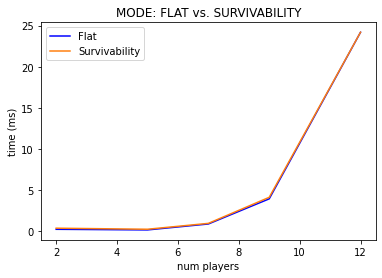

In [ ]:
plot_times_Flat_vs_Surv(num_players,flat_times,surv_times)

Such a result proves how the differences between the two models can be overcomed just by setting a proper elmination oder. Note how the custom elimination order improves both the performances for the *flat* and *survivability* modality.

Let us now analyse the behaviour of the model with some noise observations. We expect the probability of success to drop with a higher value of $BER$ along the communication path.  

We shall consider only the noise along the first path (${BER}_0$) and the input message to be known.

In [ ]:
num_players = [2,3,4,5,6]
flat_prob, surv_prob = [[] for _ in range(5)], [[] for _ in range(5)]
evidences = [{'BER_0':i, 'SOURCE':id_source_line} for i in range(5)]

In [ ]:
for num_pl in num_players:
  surv_model = TheQueryMen(num_pl,modality='survivability')
  surv_model.generateSource(source_line)

  for idx in range(5):
    surv_prob[idx].append(surv_model.makeExactQuery([f'DECODER_{num_pl}'],evidence=evidences[idx])[0])

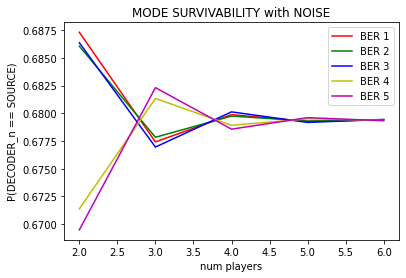

In [ ]:
colors=iter(['r','g','b','y','m'])

fig, ax = plt.subplots()
plt.title("MODE SURVIVABILITY with NOISE")

for i in range(5):
  ax.plot(num_players,surv_prob[i],next(colors),label=f'BER {i+1}')

ax.set_xlabel('num players')
ax.set_ylabel('P(DECODER_n == SOURCE)')

plt.legend()
plt.show()

## Hardcore mode

As for the previous modality, let us first compute the probability of success of the message picked initially.

In [ ]:
print(f"ORIGINAL MESSAGE: {source_line}")
print(f"MESSAGE ID: {id_source_line}\n")

hard_model = TheQueryMen(3,modality='hardcore')
id_line, str_line = surv_model.generateSource(source_line)

query = ['DECODER_3']
q=hard_model.makeExactQuery(variables=query,evidence={'SOURCE':id_source_line},printCPD=True)

ORIGINAL MESSAGE: there's nothing to tell. it's just some guy i work with.  
MESSAGE ID: 7

STATISTICS LOADED !
Building the Bayesian Network...
The BN is ready to be queried !


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

+---------------+------------------+
| DECODER_3     |   phi(DECODER_3) |
+===============+==================+
| DECODER_3(0)  |           0.0937 |
+---------------+------------------+
| DECODER_3(1)  |           0.0851 |
+---------------+------------------+
| DECODER_3(2)  |           0.0822 |
+---------------+------------------+
| DECODER_3(3)  |           0.0792 |
+---------------+------------------+
| DECODER_3(4)  |           0.0716 |
+---------------+------------------+
| DECODER_3(5)  |           0.0680 |
+---------------+------------------+
| DECODER_3(6)  |           0.0661 |
+---------------+------------------+
| DECODER_3(7)  |           0.0643 |
+---------------+------------------+
| DECODER_3(8)  |           0.0607 |
+---------------+------------------+
| DECODER_3(9)  |           0.0590 |
+---------------+------------------+
| DECODER_3(10) |           0.0585 |
+---------------+------------------+
| DECODER_3(11) |           0.0585 |
+---------------+------------------+
|

This modality makes it possible to trace the behaviour of the message accounting for the most probable destination sentence one could end up to at every endpoint of the communication. This is possible thanks to this particular Network structure that computes the probability of switching between each specific couple of available sentences. It is infact possible to witness the most probable output from  all the intermediate node in the communication path.

In [43]:
hard_model = TheQueryMen(5,modality='hardcore',num_lines=150)
id_line, str_line = hard_model.generateSource()

STATISTICS LOADED !
Building the Bayesian Network...
The BN is ready to be queried !

SOURCE MESSAGE: "look, geppetto. i'm a real live boy."  



In [44]:
prop_success = hard_model.traceSwitches(evidence={'SOURCE':id_line,'BER_0':0,'BER_1':3})

STATISTICS LOADED !
Building the Bayesian Network...
The BN is ready to be queried !


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


-----------------> PLAYER_2
+-----------------------------------------+------------------------------------+
|           INPUT (PROB. 0.014)           | MOST PROBABLE OUTPUT (PROB. 1.709) |
+=========================================+====================================+
| "look, geppetto. i'm a real live boy."  | because they are.                  |
+-----------------------------------------+------------------------------------+
STATISTICS LOADED !
Building the Bayesian Network...
The BN is ready to be queried !


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


-----------------> PLAYER_3
+---------------------------------------+--------------------------------------+
|          INPUT (PROB. 0.004)          |  MOST PROBABLE OUTPUT (PROB. 0.013)  |
+=======================================+======================================+
| "look, geppetto. i'm a real live      | la la la something and noodles with  |
| boy."                                 | string                               |
+---------------------------------------+--------------------------------------+
STATISTICS LOADED !
Building the Bayesian Network...
The BN is ready to be queried !


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]


-----------------> PLAYER_4
+-----------------------------------------+------------------------------------+
|           INPUT (PROB. 0.012)           | MOST PROBABLE OUTPUT (PROB. 1.322) |
+=========================================+====================================+
| "look, geppetto. i'm a real live boy."  | because they are.                  |
+-----------------------------------------+------------------------------------+
STATISTICS LOADED !
Building the Bayesian Network...
The BN is ready to be queried !


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]


-----------------> PLAYER_5
+---------------------------------------+--------------------------------------+
|          INPUT (PROB. 0.006)          |  MOST PROBABLE OUTPUT (PROB. 0.009)  |
+=======================================+======================================+
| "look, geppetto. i'm a real live      | i ended up living with this albino   |
| boy."                                 | guy who was cleaning windshields.    |
+---------------------------------------+--------------------------------------+


where we see the most probable output message changing multiple times along the path, given the different noise conditions.